In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

df = pd.read_csv('spambase_old.csv')
df_norm=(df-df.min())/(df.max()-df.min())
train = np.array(df.values)
train_norm = np.array(df_norm.values)
dfn = pd.read_csv('spambase_new.csv')
dfn_norm=(dfn-dfn.min())/(dfn.max()-dfn.min())
val = np.array(dfn.values)
val_norm = np.array(dfn_norm.values)

###1###

x_i*sum(O_k)-O_i

In [1509]:
###2###
def stochastic_grad(train, learning_rate = 0.0001, epoch = 300, temp = 0.995):
    w = np.random.random(train.shape[1]-1)*0.01
    w.reshape((train.shape[1]-1,1))
    b = 0
    train_z = train[:,:-1]
    y = train[:,-1]
    batch_size = 10
    loss = 0
    lr = learning_rate
    for j in range(epoch):
        lr *= temp
        for i in range(train_z.shape[0]//batch_size):
            batch = train_z[batch_size*i: batch_size*(i+1)]
            y_t = y[batch_size*i: batch_size*(i+1)]
            s = np.sum(w*batch, axis=1) + b
            x = 1/(1+np.exp(-s))
            ds = x - y_t
            dw = (1/batch_size)*np.sum((batch*ds.reshape(batch_size,1)), axis=0)
            db = (1/batch_size)*np.sum(ds)
            w -= lr*dw
            b -= lr*db
    return w, b

In [1510]:
def check_grad(w, b, dev):
    val_x = np.zeros(dev[:,:-1].shape)
    val_x += dev[:,:-1]
    s = np.sum(val_x*w,axis=1) + b
    x = 1/(1+np.exp(-s))
    rs = x>= 0.5
    y = dev[:,-1]
    return np.sum(np.abs(rs-y)/dev.shape[0])

In [1511]:
np.random.seed(13)
w1, b1 = stochastic_grad(train, 0.0001, 300, 0.995)

In [1512]:
print(check_grad(w1, b1, val))

0.105320304017


In [1513]:
w2, b2 = stochastic_grad(train_norm, 0.1, 350, 1)
dev = val_norm

In [1514]:
print(check_grad(w2, b2, val_norm))

0.0846905537459


In [1515]:
def res_grad(w, b, dev, threshold):
    val_x = np.zeros(dev[:,:-1].shape)
    val_x += dev[:,:-1]
    s = np.sum(val_x*w,axis=1) + b
    x = 1/(1+np.exp(-s))
    return x>= threshold

In [1516]:
def drawFpTp(train, val, learning_rate):    
    pr = {}
    A = np.arange(0, 1.0, 0.001)
    w1, b1 = stochastic_grad(train, learning_rate, 300, 0.995)
    for a in A:
        res_val = res_grad(w1, b1, val, a)
        fp = np.sum(1-val[res_val, -1])
        tn = np.sum(1-val[np.where(res_val, False, True), -1])
        fpr = fp/(fp + tn)
        tp = np.sum(val[res_val, -1])
        fn = np.sum(val[np.where(res_val, False, True), -1])
        tpr = tp / (tp + fn)
        pr[fpr] = tpr
    sork = np.sort(list(pr.keys()))
    val_t = []
    for k in sork:
        val_t.append(pr[k])
    plt.plot(sork, val_t, color='r')

    plt.ylim(ymax=1.01, ymin=0.0)
    plt.xlim(xmax=1.0, xmin=0.0)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    


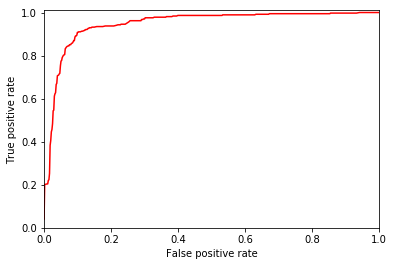

In [1517]:
drawFpTp(train, val, 0.0001)

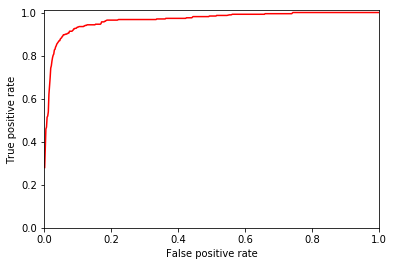

In [1518]:
drawFpTp(train_norm, val_norm, 0.1)

In [3]:
###3###
def init_param(out_dim, in_dim):
    w = np.random.randn(out_dim, in_dim)*np.sqrt(2/(out_dim + in_dim))
    b = np.zeros((out_dim, 1))
    return w, b

In [4]:
def relu(s):
    return np.where(s>0, s, 0)

In [5]:
def sigmoid(s):
    return 1/(1 + np.exp(-s))

In [6]:
def softmax(s):
    return np.exp(s)/np.sum(np.exp(s), axis=0)

In [7]:
def forward_prop_step(X_prev, w, b, activation_fun):
    s = np.dot(w, X_prev) + b
    return s, activation_fun(s)

In [8]:
def forward_prop(X_init, params, last_neuron=sigmoid):
    w1, b1, w2, b2, w3, b3 = params
    s1, X_1 = forward_prop_step(X_init, w1, b1, relu)
    s2, X_2 = forward_prop_step(X_1, w2, b2, relu)
    s3, X_3 = forward_prop_step(X_2, w3, b3, last_neuron)
    return s3, X_3, s2, X_2, s1, X_1

In [9]:
def back_prop(X_input, Y, par_lr, params):
    w1, b1, w2, b2, w3, b3 = params
    s3, X_3, s2, X_2, s1, X_1 = par_lr
    m = X_input.shape[1]
    
    ds3 = X_3 - Y
    dw3 = np.dot(ds3, X_2.T)/m
    db3 = np.sum(ds3, axis=1, keepdims=True)/m
    ds2 = np.dot(w3.T, ds3)*np.where(s2>0, 1, 0)
    dw2 = np.dot(ds2, X_1.T)/m
    db2 = np.sum(ds2, axis=1, keepdims=True)/m
    ds1 = np.dot(w2.T, ds2)*np.where(s1>0, 1, 0)
    dw1 = np.dot(ds1, X_input.T)/m
    db1 = np.sum(ds1, axis=1, keepdims=True)/m
    return dw1, db1, dw2, db2, dw3, db3

In [10]:
def init_opt(input_dim, l1_dim, l2_dim, output_dim): 
    Vdw1 = np.zeros((l1_dim, input_dim))
    Vdw2 = np.zeros((l2_dim, l1_dim))
    Vdw3 = np.zeros((output_dim, l2_dim))
    Vdb1 = np.zeros((l1_dim, 1))
    Vdb2 = np.zeros((l2_dim, 1))
    Vdb3 = np.zeros((output_dim, 1))
    Sdw1 = np.zeros((l1_dim, input_dim))
    Sdw2 = np.zeros((l2_dim, l1_dim))
    Sdw3 = np.zeros((output_dim, l2_dim))
    Sdb1 = np.zeros((l1_dim, 1))
    Sdb2 = np.zeros((l2_dim, 1))
    Sdb3 = np.zeros((output_dim, 1))
    return Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3

In [11]:
def optimize(learning_rate, weights, d_weights, adam=False, it=1, opt_cf=0, bt1 = 0.9, bt2 = 0.999, eps = 0.00000001):
    w1, b1, w2, b2, w3, b3 = weights
    dw1, db1, dw2, db2, dw3, db3 = d_weights
    if adam:
        Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3 = opt_cf
        Vdw1 = bt1*Vdw1 + (1-bt1)*dw1
        Vdb1 = bt1*Vdb1 + (1-bt1)*db1
        Sdw1 = bt2*Sdw1 + (1-bt2)*(dw1**2)
        Sdb1 = bt2*Sdb1 + (1-bt2)*(db1**2)
        Vdw2 = bt1*Vdw2 + (1-bt1)*dw2
        Vdb2 = bt1*Vdb2 + (1-bt1)*db2
        Sdw2 = bt2*Sdw2 + (1-bt2)*(dw2**2)
        Sdb2 = bt2*Sdb2 + (1-bt2)*(db2**2)
        Vdw3 = bt1*Vdw3 + (1-bt1)*dw3
        Vdb3 = bt1*Vdb3 + (1-bt1)*db3
        Sdw3 = bt2*Sdw3 + (1-bt2)*(dw3**2)
        Sdb3 = bt2*Sdb3 + (1-bt2)*(db3**2)

        Vdw1_corr = Vdw1/(1-bt1**it)
        Vdb1_corr = Vdb1/(1-bt1**it)
        Sdw1_corr = Sdw1/(1-bt2**it)  
        Sdb1_corr = Sdb1/(1-bt2**it)  
        Vdw2_corr = Vdw2/(1-bt1**it)  
        Vdb2_corr = Vdb2/(1-bt1**it)  
        Sdw2_corr = Sdw2/(1-bt2**it)  
        Sdb2_corr = Sdb2/(1-bt2**it)  
        Vdw3_corr = Vdw3/(1-bt1**it)  
        Vdb3_corr = Vdb3/(1-bt1**it)  
        Sdw3_corr = Sdw3/(1-bt2**it)  
        Sdb3_corr = Sdb3/(1-bt2**it)

        w3 = w3 - learning_rate*Vdw3_corr/(np.sqrt(Sdw3_corr)+eps)
        b3 = b3 - learning_rate*Vdb3_corr/(np.sqrt(Sdb3_corr)+eps)
        w2 = w2 - learning_rate*Vdw2_corr/(np.sqrt(Sdw2_corr)+eps)
        b2 = b2 - learning_rate*Vdb2_corr/(np.sqrt(Sdb2_corr)+eps)
        w1 = w1 - learning_rate*Vdw1_corr/(np.sqrt(Sdw1_corr)+eps)
        b1 = b1 - learning_rate*Vdb1_corr/(np.sqrt(Sdb1_corr)+eps)
        opt_cf = Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3
    else:
        w1 -= learning_rate*dw1
        b1 -= learning_rate*db1
        w2 -= learning_rate*dw2
        b2 -= learning_rate*db2
        w3 -= learning_rate*dw3
        b3 -= learning_rate*db3
    weights = w1, b1, w2, b2, w3, b3
    return weights, opt_cf

In [12]:
def nn(train, dev, l1_dim=64, l2_dim=64, out_dim=1, temp=1, learning_rate=0.1, batch_size=20, epoch=300, adam=False, last_neuron=sigmoid):
    input_dim = train.shape[1]-1
    w1, b1 = init_param(l1_dim, input_dim)
    w2, b2 = init_param(l2_dim, l1_dim)
    w3, b3 = init_param(out_dim, l2_dim)
    for i in range(epoch):
        batches_args = np.random.permutation(train.shape[0]).reshape(train.shape[0]//batch_size,batch_size)
        t=1
        Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3 = init_opt(input_dim, l1_dim, l2_dim, out_dim)
        for args in batches_args:
            batch = train[args]
            X = batch[:,:-1].T
            Y = batch[:,-1].reshape((1, batch.shape[0]))
            params = w1, b1, w2, b2, w3, b3
            par_lr = forward_prop(X, params, last_neuron)
            dw1, db1, dw2, db2, dw3, db3 = back_prop(X, Y, par_lr, params)
            opt_cf = Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3
            weights = w1, b1, w2, b2, w3, b3
            d_weights = dw1, db1, dw2, db2, dw3, db3
            weights, opt_cf = optimize(learning_rate, weights, d_weights, adam, it=t, opt_cf=opt_cf)
            w1, b1, w2, b2, w3, b3 = weights
            Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3 = opt_cf
            t+=1
        learning_rate *= temp
    param_pred = w1, b1, w2, b2, w3, b3
    _, X_3, _ , _, _, _= forward_prop(dev[:,:-1].T, param_pred)
    pred = X_3 >= 0.5
    y_d = dev[:,-1].reshape((1,dev.shape[0]))
    print("val error: " + str(np.sum(np.abs(pred-y_d)/dev.shape[0])))

In [13]:
np.random.seed(13)
nn(train_norm, val_norm, learning_rate = 0.001, temp=0.95, adam=True, epoch=100)

val error: 0.0846905537459


In [17]:
np.random.seed(13)
nn(train, val, learning_rate = 0.001, temp=0.95, adam=True, epoch=100)

val error: 0.056460369164


In [9]:
###4###
df_mnist = pd.read_csv('mnist.csv')
train_mnist = np.array(df_mnist.values)

In [10]:
classes = np.unique(train_mnist[:,0])

In [11]:
cls_data = {}
for i in classes:
    cls_data[i] = np.argwhere(train_mnist[:,0]==i)
    cls_data[i] = cls_data[i][:,0]
train_mn = np.array([np.ones(train_mnist.shape[1])])
val_mn = np.array([np.ones(train_mnist.shape[1])])
test_mn = np.array([np.ones(train_mnist.shape[1])])
for i in classes:
    ln = cls_data[i].shape[0]
    l1 = ln*8//10
    l2 = ln*9//10
    train_mn = np.concatenate((train_mn, train_mnist[cls_data[i][:l1]]), axis=0)
    val_mn = np.concatenate((val_mn, train_mnist[cls_data[i][l1:l2]]), axis=0)
    test_mn = np.concatenate((test_mn, train_mnist[cls_data[i][l2:]]), axis=0)
train_mn = train_mn[1:]
val_mn = val_mn[1:]
test_mn = test_mn[1:]
np.random.shuffle(train_mn)
np.random.shuffle(val_mn)
np.random.shuffle(test_mn)

In [19]:
print("class train  val  test")
for i in classes:
    print(str(i) + "     " + str(np.argwhere(train_mn[:,0]==i).shape[0]) +\
         "    " + str(np.argwhere(val_mn[:,0]==i).shape[0]).ljust(3) +\
        "  " + str(np.argwhere(test_mn[:,0]==i).shape[0]))

class train  val  test
0     784    98   98
1     908    113  114
2     825    103  104
3     808    101  101
4     785    98   99
5     713    89   90
6     766    96   96
7     822    103  103
8     779    97   98
9     807    101  101


In [1617]:
###5###
def nn_sm(train, dev, l1_dim=64, l2_dim=64, out_dim=1, temp=1, learning_rate=0.1, batch_size=20, epoch=300, adam=False, last_neuron=sigmoid):
    input_dim = train.shape[1]-1
    w1, b1 = init_param(l1_dim, input_dim)
    w2, b2 = init_param(l2_dim, l1_dim)
    w3, b3 = init_param(out_dim, l2_dim)
    err_pr = 1
    err = 1
    for i in range(epoch):
        t=1
        Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3 = init_opt(input_dim, l1_dim, l2_dim, out_dim)
        for i in range(int(np.ceil(train.shape[0]/batch_size))):
            r = min((i+1)*batch_size, train.shape[0])
            X = train[i*batch_size:r,1:].T
            Y_t = train[i*batch_size:r,0].reshape(X.shape[1],)
            Y = np.zeros((classes.shape[0],X.shape[1]))
            Y_t = np.array(Y_t, dtype=int)
            Y[Y_t,np.arange(X.shape[1])] += 1
            params = w1, b1, w2, b2, w3, b3
            par_lr = forward_prop(X, params, last_neuron)
            _, X_3, _ , _, _, _ = par_lr
            dw1, db1, dw2, db2, dw3, db3 = back_prop(X, Y, par_lr, params)
            opt_cf = Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3
            weights = w1, b1, w2, b2, w3, b3
            d_weights = dw1, db1, dw2, db2, dw3, db3
            weights, opt_cf = optimize(learning_rate, weights, d_weights, adam, it=t, opt_cf=opt_cf)
            w1, b1, w2, b2, w3, b3 = weights
            Vdw1, Vdw2, Vdw3, Vdb1, Vdb2, Vdb3, Sdw1, Sdw2, Sdw3, Sdb1, Sdb2, Sdb3 = opt_cf
            t+=1
        learning_rate *= temp
        
        param_pred = w1, b1, w2, b2, w3, b3
        _, X_3, _ , _, _, _= forward_prop(dev[:,1:].T, param_pred, last_neuron)
        pred = np.argmax(X_3, axis=0)
        y_d = dev[:,0].reshape((1,dev.shape[0]))
        div = pred - y_d
        div = np.where(div==0, div, 1)
        err = np.sum(div/dev.shape[0])
        if err == err_pr:
            break
        err_pr = err
    print("val error: " + str(err))
    return w1, b1, w2, b2, w3, b3

In [1620]:
np.random.seed(13)
params = nn_sm(train_mn, val_mn, batch_size=10, learning_rate = 0.001, temp=0.95, adam=True, epoch=100, last_neuron = softmax, out_dim = 10)
_, X_3, _ , _, _, _= forward_prop(test[:,1:].T, params, softmax)
pred = np.argmax(X_3, axis=0)
y_d = test[:,0].reshape((1,test.shape[0]))
div = pred - y_d
div = np.where(div==0, div, 1)
err = np.sum(div/test.shape[0])
print("test error: " + str(err))

val error: 0.042042042042
test error: 0.0646766169154
